In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import tfoptym
reload(tfoptym)
import prysm
prysm.__file__


'/opt/anaconda3/envs/gradfilms/lib/python3.11/site-packages/prysm/__init__.py'

In [2]:
from tfoptym import mathops
mathops.set_backend_to_numpy()

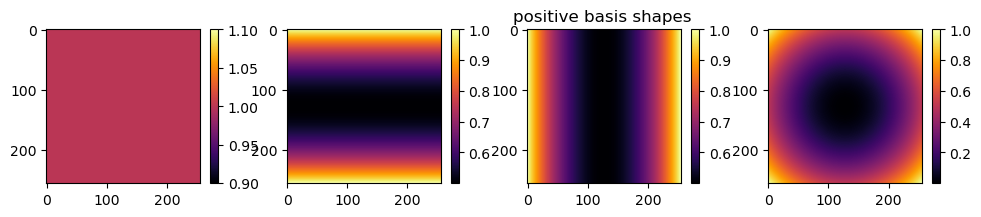

In [3]:
# Try the polynomial computation
from tfoptym.polynomials import gen_positive_polynomial_basis
basis = gen_positive_polynomial_basis(nterms=3)

plt.figure(figsize=[15,2])
plt.suptitle('positive basis shapes')
for i,func in enumerate(basis):
    plt.subplot(1,len(basis)+1,i+1)
    plt.imshow(func,cmap='inferno')
    plt.colorbar()
plt.subplots_adjust()
plt.show()

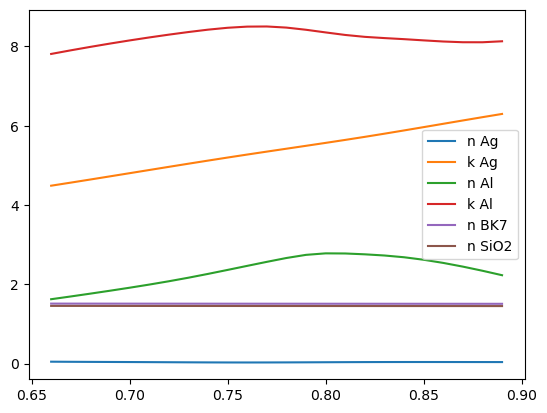

In [4]:
Ag_model = np.array([[0.4959,	0.05,	3.093],
                    [0.5209,	0.05,	3.324],
                    [0.5486,	0.06,	3.586],
                    [0.5821,	0.05,	3.858],
                    [0.6168,	0.06,	4.152],
                    [0.6595,  0.05,	4.483],
                    [0.7045,	0.04,	4.838],
                    [0.756,	0.03,	5.242],
                    [0.8211,	0.04,	5.727],
                    [0.892,	0.04,	6.312],
                    [0.984,	0.04,	6.992],
                    [1.088,	0.04,	7.795],
                    [1.216,	0.09,	8.828]]).transpose() # 0 is wlen, 1 is n, 2 is k

Al_model = np.array([
    [0.61993,	1.366,	7.4052],
    [0.65225,	1.5724,	7.7354],
    [0.68881,	1.8301,	8.0601],
    [0.72932,	2.1606,	8.3565],
    [0.77491,	2.6154,	8.4914],
    [0.79478,	2.7675,	8.3866],
    [0.81569,	2.7668,	8.2573],
    [0.83774,	2.6945,	8.1878],
    [0.88561,	2.2802,	8.1134],
    [0.91166,	1.9739,	8.3058]
]).transpose()

BK7_model = np.array([[0.652,	1.5144566604974599],
    [0.674,	1.5137878897669719],
    [0.696,	1.513171111794838],
    [0.718,	1.51259940245443],
    [0.74,	1.512066894864639],
    [0.762,	1.5115685899968851],
    [0.784,	1.511100205933553],
    [0.806,	1.510658056970485],
    [0.828,	1.510238955962558],
    [0.85,	1.5098401349174289],
    [0.872,	1.50945918002393],
    [0.894,	1.509093978179181]]).transpose()

SiO2_model = np.array([[0.6584,	1.456310408017526],
[0.6816,	1.455724698695758],
[0.7056,	1.455166029922115],
[0.7305,	1.454629875453817],
[0.7562,	1.454116165084212],
[0.7829,	1.45361885362473],
[0.8104,	1.453139610263754],
[0.839,	1.4526712743321681],
[0.8686,	1.452213820573103],
[0.8992,	1.451765383474718]]).transpose()

# create interpolated refractive index models
from scipy.interpolate import CubicSpline
f_n_Ag = CubicSpline(Ag_model[0],Ag_model[1])
f_k_Ag = CubicSpline(Ag_model[0],Ag_model[2])

f_n_Al = CubicSpline(Al_model[0],Al_model[1])
f_k_Al = CubicSpline(Al_model[0],Al_model[2])

f_n_BK7 = CubicSpline(BK7_model[0],BK7_model[1])

f_n_SiO2 = CubicSpline(SiO2_model[0],SiO2_model[1])

wlens = np.arange(0.660,0.90,0.01)

plt.figure()
plt.plot(wlens,f_n_Ag(wlens),label='n Ag')
plt.plot(wlens,f_k_Ag(wlens),label='k Ag')
plt.plot(wlens,f_n_Al(wlens),label='n Al')
plt.plot(wlens,f_k_Al(wlens),label='k Al')
plt.plot(wlens,f_n_BK7(wlens),label='n BK7')
plt.plot(wlens,f_n_SiO2(wlens),label='n SiO2')
plt.legend()
plt.show()

In [5]:
import old_thinfilm
import prysm.thinfilm
reload(old_thinfilm)
reload(prysm.thinfilm)
from tfoptym.thinfilms import compute_thin_films_byu,compute_thin_films_macleod
from prysm.thinfilm import multilayer_stack_rt
from old_thinfilm import multilayer_stack_rt as old_multilayer_stack_rt

wvl = .587725e-6
angles = np.arange(0,60,3)
n_MgF2 = 1.3698
n_ZrO2 = 2.1588
n_CeF3 = 1.6290 + 1j * 0.0034836
n_CeF3_m = 1.6290 - 1j * 0.0034836
n_C7980 = 1.458461

stack_p = [
        (n_MgF2, wvl/4),
        (n_ZrO2, wvl/2),
        (n_CeF3, wvl/4),
        (n_C7980, 10_000_000)
    ]

stack = [
        (n_MgF2, wvl/4),
        (n_ZrO2, wvl/2),
        (n_CeF3, wvl/4),
        (n_C7980, 10_000_000)
    ]
arraystack = np.asarray(stack)
arraystack = np.moveaxis(arraystack,-1,0)

stack_mac = [
        (n_MgF2, wvl/4),
        (n_ZrO2, wvl/2),
        (n_CeF3_m, wvl/4)
    ]

# stack = [((1.7746511990429559+0j), 1.2062e-07),
#  ((2.419899033284391+0j), 3.856e-08),
#  ((1.7746511990429559+0j), 5.268e-08),
#  ((0.13000230590097622+2.9171482186130557j), 2.8919e-07),
#  ((1.52141388), 10000)]

# stack_mac = [((1.7746511990429559+0j), 1.2062e-07),
#  ((2.419899033284391+0j), 3.856e-08),
#  ((1.7746511990429559+0j), 5.268e-08),
#  ((0.13000230590097622-2.9171482186130557j), 2.8919e-07),
#  ((1.52141388), 10000)]



rsblist,rpblist = [],[]
rsmlist,rpmlist = [],[]
rsplist,rpplist = [],[]
rsolist,rpolist = [],[]
for aoi in angles:
    # print('aoi = ',aoi,'deg or ',np.radians(aoi),'rad')
    rsm,rpm = compute_thin_films_macleod(stack_mac,aoi/180*np.pi,wvl,substrate_index=n_C7980)
    rsb,_ = compute_thin_films_byu(stack[:-1],aoi/180*np.pi,wvl,substrate_index=n_C7980,polarization='s')
    rpb,_ = compute_thin_films_byu(stack[:-1],aoi/180*np.pi,wvl,substrate_index=n_C7980,polarization='p')
    rsp,_ = multilayer_stack_rt(stack_p,wvl,'s',aoi=aoi)
    rpp,_ = multilayer_stack_rt(stack_p,wvl,'p',aoi=aoi)
    rso,_ = old_multilayer_stack_rt('s',wvl,stack,aoi=aoi)
    rpo,_ = old_multilayer_stack_rt('p',wvl,stack,aoi=aoi)
    rsblist.append(np.abs(rsb)**2)
    rpblist.append(np.abs(rpb)**2)
    rsmlist.append(np.abs(rsm)**2)
    rpmlist.append(np.abs(rpm)**2)
    rsplist.append(np.abs(rsp)**2)
    rpplist.append(np.abs(rpp)**2)
    rsolist.append(np.abs(rso)**2)
    rpolist.append(np.abs(rpo)**2)

In [6]:
print(rsplist)
print(rpplist)

[0.002608801960562358, 0.002531243505722384, 0.002371939689362451, 0.002339485196017554, 0.0027409361785657492, 0.0039154718097550775, 0.00613848768214502, 0.009509314561540015, 0.013855343135893502, 0.01870189216009186, 0.02335710399264645, 0.027135303259396795, 0.02969188479185334, 0.0313743900281277, 0.03341403795132828, 0.0377203937515863, 0.046105895514371886, 0.05909371507871755, 0.07494868915009138, 0.08972741577437647]
[0.002608801960562358, 0.002556631876839926, 0.002486348395958267, 0.002629172261007617, 0.0032815422903947826, 0.004684417416580289, 0.006889390737489485, 0.009658665966170444, 0.01245458835439655, 0.014557641773526383, 0.015306312110345426, 0.014390480021531562, 0.012072413661788796, 0.009181859051776552, 0.006780140619558149, 0.005565090137392658, 0.005351269684583426, 0.005089229862640385, 0.003690482961061041, 0.0016078342894105414]


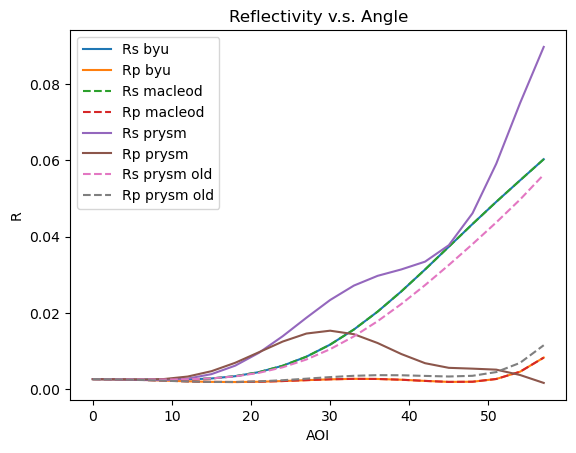

In [7]:
plt.figure()
plt.plot(angles,rsblist,label='Rs byu')
plt.plot(angles,rpblist,label='Rp byu')
plt.plot(angles,rsmlist,label='Rs macleod',linestyle='dashed')
plt.plot(angles,rpmlist,label='Rp macleod',linestyle='dashed')
plt.plot(angles,rsplist,label='Rs prysm')
plt.plot(angles,rpplist,label='Rp prysm')
plt.plot(angles,rsolist,label='Rs prysm old',linestyle='dashed')
plt.plot(angles,rpolist,label='Rp prysm old',linestyle='dashed')
plt.legend()
plt.title('Reflectivity v.s. Angle')
plt.ylabel('R')
plt.xlabel('AOI')
plt.show()

In [24]:
import old_thinfilm
import prysm.thinfilm
reload(old_thinfilm)
reload(prysm.thinfilm)
from tfoptym.thinfilms import compute_thin_films_byu,compute_thin_films_macleod
from prysm.thinfilm import multilayer_stack_rt
from old_thinfilm import multilayer_stack_rt as old_multilayer_stack_rt

angles = [30] #np.arange(30,59,30)

rsblist,rpblist = [],[]
rsmlist,rpmlist = [],[]
rsplist,rpplist = [],[]
rsolist,rpolist = [],[]

tsblist,tpblist = [],[]
tsmlist,tpmlist = [],[]
tsplist,tpplist = [],[]
tsolist,tpolist = [],[]

for wvl in wlens:
    for aoi in angles:

        # Update the Stack
        stack = [
            (f_n_SiO2(wvl),0.250),
            (f_n_BK7(wvl),0.100),
            (f_n_SiO2(wvl),0.250),
            (f_n_Al(wvl) + 1j*f_k_Al(wvl),0.0100),
            (f_n_BK7(wvl), 100_000_000_000)
        ]
        
        # Update the Stack
        stack_mac = [
            (f_n_SiO2(wvl),0.250),
            (f_n_BK7(wvl),0.100),
            (f_n_SiO2(wvl),0.250),
            (f_n_Al(wvl) - 1j*f_k_Al(wvl),0.0100)
        ]

        # print('aoi = ',aoi,'deg or ',np.radians(aoi),'rad')
        rsm,rpm = compute_thin_films_macleod(stack_mac,aoi/180*np.pi,wvl,substrate_index=f_n_BK7(wvl))
        tsm,tpm = compute_thin_films_macleod(stack_mac,aoi/180*np.pi,wvl,substrate_index=f_n_BK7(wvl))
        rsb,tsb = compute_thin_films_byu(stack[:-1],aoi/180*np.pi,wvl,substrate_index=f_n_BK7(wvl),polarization='s')
        rpb,tpb = compute_thin_films_byu(stack[:-1],aoi/180*np.pi,wvl,substrate_index=f_n_BK7(wvl),polarization='p')
        rsp,tsp = multilayer_stack_rt(stack,wvl,'s',aoi=aoi)
        rpp,tpp = multilayer_stack_rt(stack,wvl,'p',aoi=aoi)
        rso,tso = old_multilayer_stack_rt('s',wvl,stack,aoi=aoi)
        rpo,tpo = old_multilayer_stack_rt('p',wvl,stack,aoi=aoi)

        rsblist.append(np.abs(rsb)**2)
        rpblist.append(np.abs(rpb)**2)
        rsmlist.append(np.abs(rsm)**2)
        rpmlist.append(np.abs(rpm)**2)
        rsplist.append(np.abs(rsp)**2)
        rpplist.append(np.abs(rpp)**2)
        rsolist.append(np.abs(rso)**2)
        rpolist.append(np.abs(rpo)**2)

        tsblist.append(np.abs(tsb)**2)
        tpblist.append(np.abs(tpb)**2)
        tsmlist.append(np.abs(tsm)**2)
        tpmlist.append(np.abs(tpm)**2)
        tsplist.append(np.abs(tsp)**2)
        tpplist.append(np.abs(tpp)**2)
        tsolist.append(np.abs(tso)**2)
        tpolist.append(np.abs(tpo)**2)

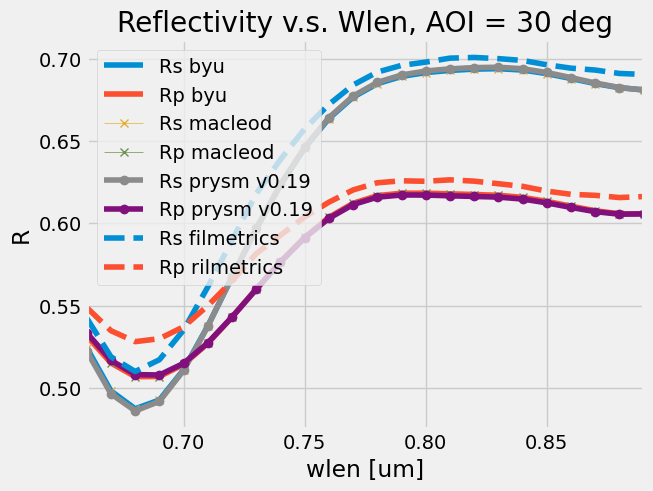

In [28]:
angle = angles[0]
pth_Rs = f'test_data/Rs_{angle}deg.txt'
pth_Rp = f'test_data/Rp_{angle}deg.txt'
Rs_filmetrics = np.genfromtxt(pth_Rs,delimiter='\t',skip_header=1)
Rp_filmetrics = np.genfromtxt(pth_Rp,delimiter='\t',skip_header=1)

# make a spline on the data
Rs_filmetrics_model = CubicSpline(Rs_filmetrics[...,0]*1e-3,Rs_filmetrics[...,1])
Rp_filmetrics_model = CubicSpline(Rp_filmetrics[...,0]*1e-3,Rp_filmetrics[...,1])

plt.figure()
plt.style.use('fivethirtyeight')
plt.plot(wlens,rsblist,label='Rs byu',linestyle='solid')
plt.plot(wlens,rpblist,label='Rp byu',linestyle='solid')
plt.plot(wlens,rsmlist,label='Rs macleod',marker='x',linewidth=0.5)
plt.plot(wlens,rpmlist,label='Rp macleod',marker='x',linewidth=0.5)
plt.plot(wlens,rsolist,label='Rs prysm v0.19',marker='o')
plt.plot(wlens,rpolist,label='Rp prysm v0.19',marker='o')
# plt.plot(wlens,rsplist,label='Rs prysm v0.21')
# plt.plot(wlens,rpplist,label='Rp prysm v0.21')
# plt.plot(wlens,np.array(rsolist)-np.array(rsplist),label='Rs v0.19 - v0.21')
plt.plot(wlens,Rs_filmetrics_model(wlens),label='Rs filmetrics',linestyle='dashed')
plt.plot(wlens,Rp_filmetrics_model(wlens),label='Rp rilmetrics',linestyle='dashed')
plt.legend()
plt.title(f'Reflectivity v.s. Wlen, AOI = {angle} deg')
plt.ylabel('R')
plt.xlabel('wlen [um]')
plt.xlim([0.66,0.89])
plt.show()

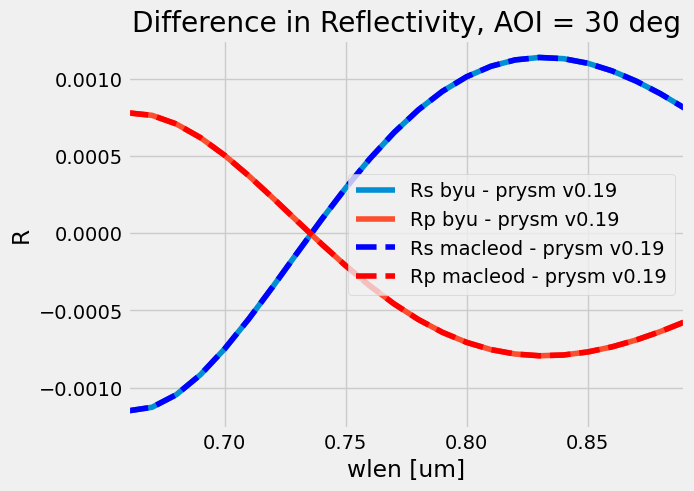

In [23]:
plt.figure()
plt.style.use('fivethirtyeight')
plt.plot(wlens,np.array(rsblist)-np.array(rsolist),label='Rs byu - prysm v0.19')
plt.plot(wlens,np.array(rpblist)-np.array(rpolist),label='Rp byu - prysm v0.19')
plt.plot(wlens,np.array(rsmlist)-np.array(rsolist),label='Rs macleod - prysm v0.19',linestyle='dashed',color='blue')
plt.plot(wlens,np.array(rpmlist)-np.array(rpolist),label='Rp macleod - prysm v0.19',linestyle='dashed',color='red')
# plt.plot(wlens,rsolist,label='Rs prysm v0.19',linestyle='solid',color='blue',alpha=0.25,linewidth=8)
# plt.plot(wlens,rpolist,label='Rp prysm v0.19',linestyle='solid',color='red',alpha=0.25,linewidth=8)
# plt.plot(wlens,rsplist,label='Rs prysm v0.21')
# plt.plot(wlens,rpplist,label='Rp prysm v0.21')
# plt.plot(wlens,Rs_filmetrics_model(wlens),label='Rs filmetrics',linestyle='dashed',color='blue')
# plt.plot(wlens,Rp_filmetrics_model(wlens),label='Rp rilmetrics',linestyle='dashed',color='red')
plt.legend()
plt.title(f'Difference in Reflectivity, AOI = {angle} deg')
plt.ylabel('R')
plt.xlabel('wlen [um]')
plt.xlim([0.66,0.89])
plt.show()